In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [23]:
from os import listdir, mkdir
from os.path import dirname, isdir
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
from random import sample
import zipfile as z
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras import Sequential, layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, \
                                      LearningRateScheduler

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
path = "/kaggle/input/age-detection/"
IMG_SIZE = (196, 196, 3)
BATCH_SIZE = 64

In [5]:
if not Path(path + "train").is_dir(): mkdir(path + "train")
if not Path(path + "test").is_dir(): mkdir(path + "test")

# with z.ZipFile(path + "train.zip") as zr:
#     zr.extractall(path + "train")

# with z.ZipFile(path + "test.zip") as zr:
#     zr.extractall(path + "test")

In [13]:
images_path = path + "train/"
train_df = pd.read_csv(path + "/train/train.csv")

sampled_df = pd.DataFrame()
n_oversample = 3

sampled_df = sampled_df.append(train_df.loc[train_df.Class=="YOUNG"])
sampled_df = sampled_df.append(train_df.loc[train_df.Class=="MIDDLE"].sample(7000))
for i in range(n_oversample):
    sampled_df = sampled_df.append(train_df.loc[train_df.Class=="OLD"])

# labels = train_df.Class.astype("category").cat.codes.to_list()

In [14]:
train_df.Class.value_counts(), sampled_df.Class.value_counts()

(MIDDLE    10804
 YOUNG      6706
 OLD        2396
 Name: Class, dtype: int64,
 OLD       7188
 MIDDLE    7000
 YOUNG     6706
 Name: Class, dtype: int64)

In [15]:
# train_df = train_df.sample(8000)

labels_df = pd.get_dummies(sampled_df.Class)
label_names = labels_df.columns.to_list()
labels = list(labels_df.values)

sampled_df = sampled_df.assign(labels=labels)

x_train, x_val = train_test_split(sampled_df, test_size=0.25)
x_train.shape, x_val.shape

((15670, 3), (5224, 3))

In [16]:
basedir = images_path + "Train/"

train_images = []

for img_name in x_train.ID:
    img_path = basedir + img_name
    img = cv2.imread(img_path)
    train_images.append(cv2.resize(img, dsize=IMG_SIZE[:-1]))

In [17]:
val_images = []

for img_name in x_val.ID:
    img_path = basedir + img_name
    img = cv2.imread(img_path)
    val_images.append(cv2.resize(img, dsize=IMG_SIZE[:-1]))

In [18]:
with tf.device("/device:GPU:0"):
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, x_train.labels.to_list()))

In [19]:
with tf.device("/device:GPU:0"):
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, x_val.labels.to_list()))

[0 0 1]


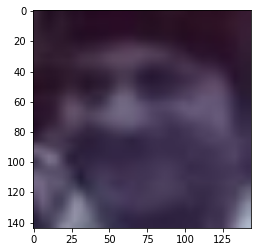

In [20]:
image, label = next(iter(train_dataset))
print(label.numpy())
imshow(image.numpy().astype(int))

In [21]:
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [60]:
data_aug = Sequential([
    layers.ZeroPadding2D(3),
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomTranslation((-0.01, 0.01), (-0.01, 0.01), fill_mode="constant"),
    layers.experimental.preprocessing.RandomZoom((-.05, .05)),
    layers.experimental.preprocessing.RandomRotation((-0.05, 0.05)),
    # layers.experimental.preprocessing.Rescaling(1./255),
    # layers.experimental.preprocessing.RandomContrast(0.90),
])

# preprocess = tf.keras.applications.resnet50.preprocess_input
# preprocess = tf.keras.applications.inception_resnet_v2.preprocess_input
# preprocess = tf.keras.applications.densenet.preprocess_input
preprocess = tf.keras.applications.vgg19.preprocess_input

In [79]:
# base_model = DenseNet121(include_top=False, input_shape=IMG_SIZE, weights="imagenet")
base_model = VGG19(include_top=False, input_shape=IMG_SIZE, weights="imagenet")
# base_model = ResNet50(include_top=False, input_shape=IMG_SIZE, weights="imagenet")
# base_model = InceptionResNetV2(include_top=False, input_shape=IMG_SIZE, weights="imagenet")


In [81]:
base_model.trainable = False

clf_layers = Sequential([
    layers.GlobalMaxPooling2D(),
    layers.Dropout(0.4),
    layers.Dense(512, activation="relu"),
#     layers.Dropout(0.5),
#     layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(3, activation="softmax")
])

In [82]:
inputs = tf.keras.Input(shape=IMG_SIZE)
x = data_aug(inputs)
x = preprocess(inputs)
x = base_model(x)
outputs = clf_layers(x)

model = Model(inputs, outputs)

base_lr = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 144, 144, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 144, 144, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 144, 144, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
sequential_7 (Sequential)    (None, 3)                 264195    
Total params: 20,288,579
Trainable params: 264,195
Non-trainable params: 20,024,384
_________________________________________________________________


In [83]:
def scheduler(epochs, lr):
    return lr if epochs<10 else lr * tf.math.exp(-0.1)
  

cp_path = dirname("./models/cp.ckpt")
cp_callback = ModelCheckpoint(filepath=cp_path, save_weights_only=True, 
                              save_best_only=True, monitor="val_accuracy")

es_callback = EarlyStopping(monitor="val_accuracy", patience=10, verbose=1, baseline=0.60)
lr_callback = LearningRateScheduler(schedule=scheduler, verbose=5)

callbacks = [cp_callback, es_callback, lr_callback]

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [84]:
epochs = 50
with tf.device("/device:GPU:0"):
    model.fit(train_dataset, epochs=epochs, shuffle=True,
              validation_data=val_dataset, callbacks=[callbacks])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
245/245 [==============================] - 23s 90ms/step - loss: 7.2876 - accuracy: 0.4473 - val_loss: 0.9936 - val_accuracy: 0.5159
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
245/245 [==============================] - 22s 89ms/step - loss: 1.1250 - accuracy: 0.5082 - val_loss: 0.9617 - val_accuracy: 0.5494
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
245/245 [==============================] - 22s 90ms/step - loss: 0.9751 - accuracy: 0.5436 - val_loss: 0.9001 - val_accuracy: 0.6038
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
245/245 [==============================] - 22s 90ms/step - loss: 0.9057 - accuracy: 0.5856 - val_loss: 0.8805 - val_accuracy: 0.5926
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001000000

In [85]:
model.load_weights(cp_path)

In [86]:
len(base_model.layers)

22

In [87]:
fine_tune_at = 20
base_model.trainable = True

for (idx, layer) in enumerate(base_model.layers):
    if (idx < fine_tune_at) or layer.name.endswith("bn"):
        layer.trainable = False

In [88]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr / 10),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 144, 144, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 144, 144, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 144, 144, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
sequential_7 (Sequential)    (None, 3)                 264195    
Total params: 20,288,579
Trainable params: 2,624,003
Non-trainable params: 17,664,576
_________________________________________________________________


In [89]:
epochs = 50
with tf.device("/device:GPU:0"):
    model.fit(train_dataset, epochs=epochs, shuffle=True,
              validation_data=val_dataset, callbacks=[callbacks])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
245/245 [==============================] - 24s 94ms/step - loss: 0.5556 - accuracy: 0.7630 - val_loss: 0.5460 - val_accuracy: 0.7774
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
245/245 [==============================] - 23s 93ms/step - loss: 0.4730 - accuracy: 0.8034 - val_loss: 0.4932 - val_accuracy: 0.7963
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
245/245 [==============================] - 23s 93ms/step - loss: 0.3977 - accuracy: 0.8405 - val_loss: 0.4460 - val_accuracy: 0.8143
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
245/245 [==============================] - 23s 92ms/step - loss: 0.3572 - accuracy: 0.8571 - val_loss: 0.4424 - val_accuracy: 0.8137
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 9.999999747

In [90]:
model.load_weights(cp_path)

In [91]:
model.evaluate(val_dataset), model.evaluate(train_dataset)

245/245 [==============================] - 18s 67ms/step - loss: 0.0040 - accuracy: 0.9998


([0.395156592130661, 0.8771056532859802],
 [0.003967784345149994, 0.9998085498809814])

In [41]:
test_df = pd.read_csv(path+"test/test.csv")
test_images = []
basedir = path + "test/Test/"

for img_name in test_df.ID:
    img_path = basedir + img_name
    img = cv2.imread(img_path)
    test_images.append(cv2.resize(img, dsize=IMG_SIZE[:-1]))

In [42]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [92]:
preds = model.predict(test_dataset)

In [93]:
submission = pd.read_csv(path+"sample_submission.csv")
submission.head()

,Class,ID
0,MIDDLE,25321.jpg
1,MIDDLE,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg


In [94]:
submission = submission.assign(Class=np.array(label_names)[np.argmax(preds, axis=1)])
submission.to_csv("submission.csv", index=None)